# Prédiction des taux directeurs à l'aide des discours de la FED

## I - EDA

### 1 - Librairies

In [61]:
import kagglehub
import shutil
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

#Zoom EDA
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

#Nettoyage
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#Modèle TF-IDF + LR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

#Modèle TF-IDF + MNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score

### 2 - Data importation

In [2]:
destination_path = r"C:\Users\Lia\OneDrive - Université Paris 1 Panthéon-Sorbonne\Bureau\MASTER 2\S2\NLP\DATA"
download_path = kagglehub.dataset_download("natanm/federal-reserve-governors-speeches-1996-2020")

os.makedirs(destination_path, exist_ok=True)

for file_name in os.listdir(download_path):
    shutil.move(os.path.join(download_path, file_name), os.path.join(destination_path, file_name))

print("Données déplacées vers :", destination_path)

Données déplacées vers : C:\Users\Lia\OneDrive - Université Paris 1 Panthéon-Sorbonne\Bureau\MASTER 2\S2\NLP\DATA


#### Charger les données

In [22]:
path = r"C:\Users\Lia\OneDrive - Université Paris 1 Panthéon-Sorbonne\Bureau\MASTER 2\S2\NLP\DATA\fed_speeches_1996_2024.csv"
df = pd.read_csv(path)

In [23]:
path_rates = r'C:\Users\Lia\OneDrive - Université Paris 1 Panthéon-Sorbonne\Bureau\MASTER 2\S2\NLP\DATA\FEDFUNDS.csv'
df_rates = pd.read_csv(path_rates)

In [11]:
df.head(2)

,date,title,speaker,text
0,1996-06-13 00:00:00,Bank supervision in a world economy,Chairman Alan Greenspan,Remarks by Chairman Alan Greenspan Bank superv...
1,1996-06-18 00:00:00,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.","Remarks by Governor Edward W. Kelley, Jr. Deve..."


In [12]:
df_rates.head(2)

,observation_date,FEDFUNDS
0,1995-01-01,5.53
1,1995-02-01,5.92


### 3 - Statistiques globales

In [7]:
print(df.shape)
print(df.info())
print(df.nunique())

(1823, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1823 entries, 0 to 1822
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     1821 non-null   object
 1   title    1822 non-null   object
 2   speaker  1820 non-null   object
 3   text     1823 non-null   object
dtypes: object(4)
memory usage: 57.1+ KB
None
date       1508
title      1562
speaker      43
text       1815
dtype: int64


In [8]:
print(df_rates.shape)
print(df_rates.info())

(362, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  362 non-null    object 
 1   FEDFUNDS          362 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


### 4 - Data transformation

#### Format dates

In [24]:
df = df.dropna(subset=["date"])

In [25]:
df["date"] = pd.to_datetime(df["date"], errors='coerce')

In [26]:
df["date_cible"] = df["date"] + pd.offsets.MonthBegin(1)
df = df.rename(columns={"date": "date_speech"})
df.head(2)


,date_speech,title,speaker,text,date_cible
0,1996-06-13,Bank supervision in a world economy,Chairman Alan Greenspan,Remarks by Chairman Alan Greenspan Bank superv...,1996-07-01
1,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.","Remarks by Governor Edward W. Kelley, Jr. Deve...",1996-07-01


In [27]:
df_rates["observation_date"] = pd.to_datetime(df_rates["observation_date"])

#### Labélisation

In [28]:
df_rates["Diff"] = df_rates["FEDFUNDS"].diff()
df_rates["FEDFUNDS_classes"] = df_rates["Diff"].apply(lambda x: "Augmentation" if x > 0 else ("Baisse" if x < 0 else "Stable"))

# Application du One-Hot Encoding
df_rates = pd.get_dummies(df_rates, columns=["FEDFUNDS_classes"], prefix="FEDFUNDS")
fedfunds_cols = [col for col in df_rates.columns if col.startswith("FEDFUNDS_")]
df_rates[fedfunds_cols] = df_rates[fedfunds_cols].astype(int)
df_rates.head(4)

,observation_date,FEDFUNDS,Diff,FEDFUNDS_Augmentation,FEDFUNDS_Baisse,FEDFUNDS_Stable
0,1995-01-01,5.53,NaN,0,0,1
1,1995-02-01,5.92,0.39,1,0,0
2,1995-03-01,5.98,0.06,1,0,0
3,1995-04-01,6.05,0.07,1,0,0


In [29]:
df_rates = df_rates.dropna(subset=["Diff"])

In [30]:
mean_diff = df_rates["Diff"].mean()
print(f"Moyenne des variations du taux directeur : {mean_diff:.4f}")

Moyenne des variations du taux directeur : -0.0033


**Visualisation de l'évolution des taux directeurs de la FED**

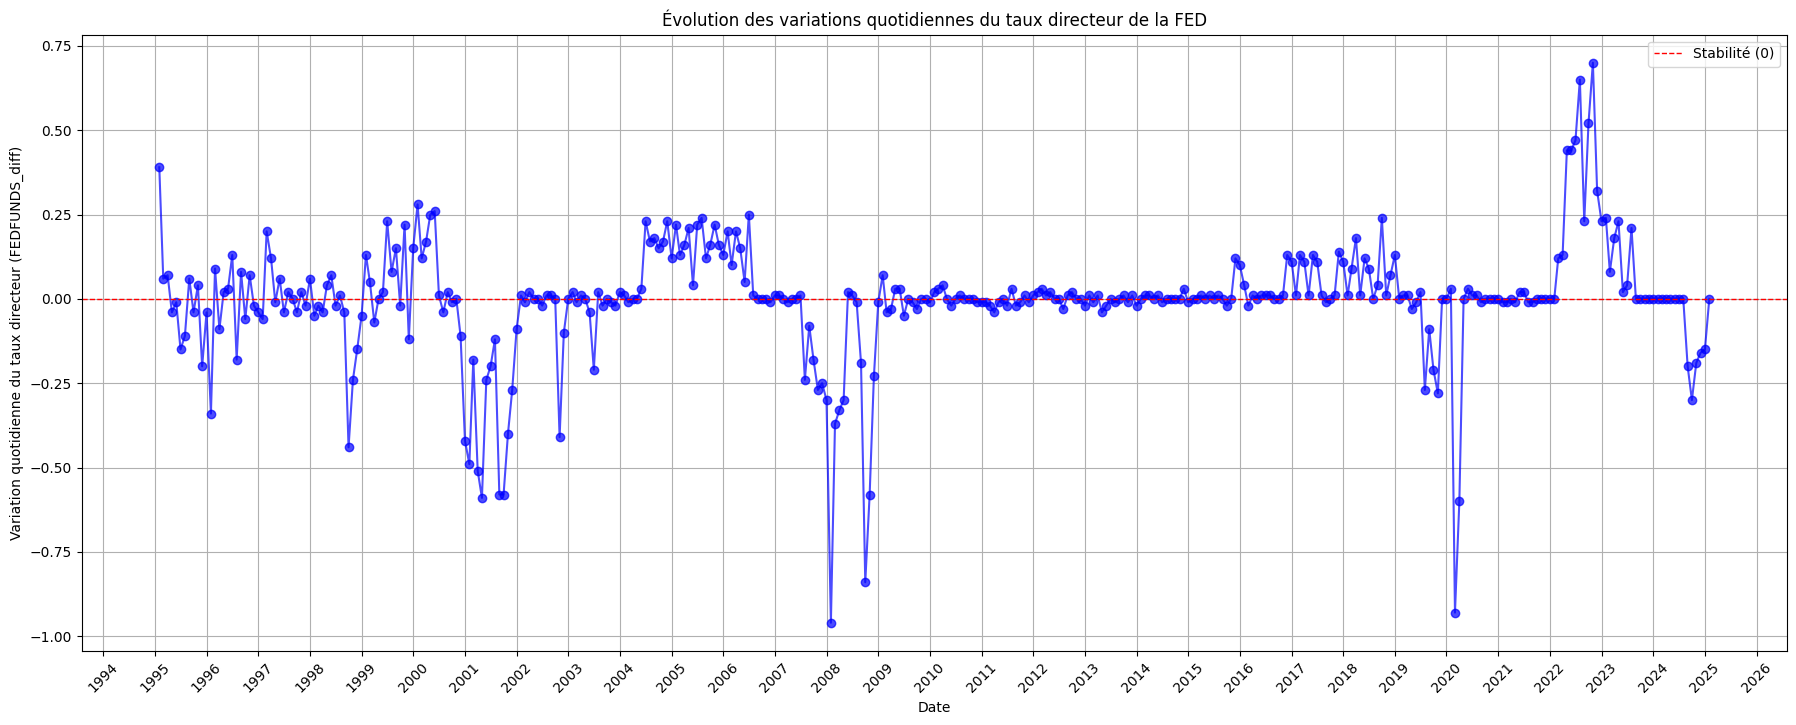

In [31]:
plt.figure(figsize=(22, 8))
plt.plot(df_rates["observation_date"], df_rates["Diff"], marker="o", linestyle="-", color="b", alpha=0.7)
plt.axhline(0, color="red", linestyle="dashed", linewidth=1, label="Stabilité (0)")

plt.gca().xaxis.set_major_locator(mdates.YearLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  

plt.xlabel("Date")
plt.ylabel("Variation quotidienne du taux directeur (FEDFUNDS_diff)")
plt.title("Évolution des variations quotidiennes du taux directeur de la FED")
plt.xticks(rotation=45)  
plt.legend()
plt.grid(True)

plt.show()


**Distribution des classes**

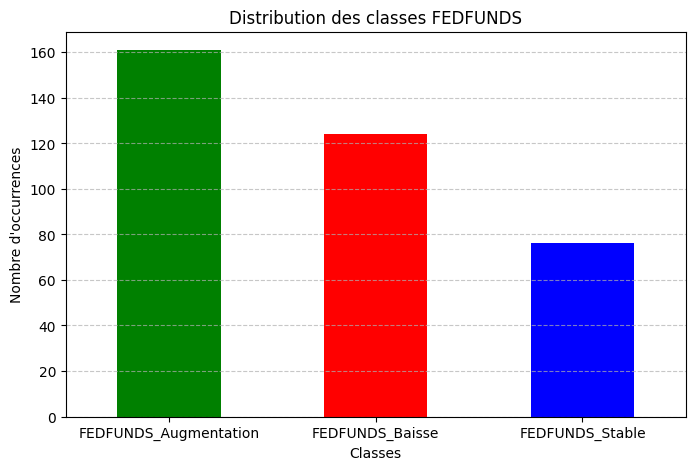

In [32]:
class_counts = df_rates[["FEDFUNDS_Augmentation", "FEDFUNDS_Baisse", "FEDFUNDS_Stable"]].sum()

plt.figure(figsize=(8, 5))
class_counts.plot(kind="bar", color=["green", "red", "blue"])
plt.xlabel("Classes")
plt.ylabel("Nombre d'occurrences")
plt.title("Distribution des classes FEDFUNDS")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### 5 - Concaténation des dataframes

In [33]:
df_merged = pd.merge(df, df_rates, left_on="date_cible", right_on="observation_date", how="inner")
df_merged.drop(columns=["observation_date"], inplace=True)
df = df_merged

In [34]:
df.head()

,date_speech,title,speaker,text,date_cible,FEDFUNDS,Diff,FEDFUNDS_Augmentation,FEDFUNDS_Baisse,FEDFUNDS_Stable
0,1996-06-13,Bank supervision in a world economy,Chairman Alan Greenspan,Remarks by Chairman Alan Greenspan Bank superv...,1996-07-01,5.40,0.13,1,0,0
1,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.","Remarks by Governor Edward W. Kelley, Jr. Deve...",1996-07-01,5.40,0.13,1,0,0
2,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,Monetary Policy Objectives and Strategy I wan...,1996-10-01,5.24,-0.06,0,1,0
3,1996-09-19,Regulation and electronic payment systems,Chairman Alan Greenspan,Remarks by Chairman Alan Greenspan Regulation ...,1996-10-01,5.24,-0.06,0,1,0
4,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,Remarks by Governor Lawrence B. Lindsey At the...,1996-11-01,5.31,0.07,1,0,0


In [35]:
df.shape

(1821, 10)

### 6 - Zoom EDA

#### Fréquence stopwords corpus complet

In [36]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
def get_most_frequent_words(texts, stop_words):
    all_words = []
    for text in texts:
        words = re.findall(r'\b\w+\b', str(text).lower())  
        filtered_words = [word for word in words if word not in stop_words]  # Supprime les stopwords
        all_words.extend(filtered_words)

    return Counter(all_words).most_common(20)  # Retourne les 20 mots les plus fréquents

# Utilisation avec un DataFrame `df`
common_words = get_most_frequent_words(df["text"], stop_words)

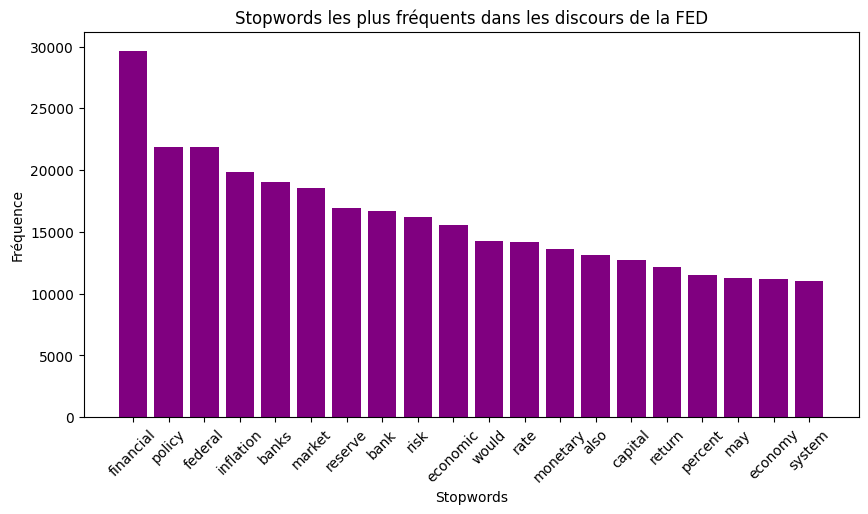

In [38]:
words, counts = zip(*common_words)

plt.figure(figsize=(10, 5))
plt.bar(words, counts, color="purple")
plt.xlabel("Stopwords")
plt.ylabel("Fréquence")
plt.title("Stopwords les plus fréquents dans les discours de la FED")
plt.xticks(rotation=45)
plt.show()

#### Fréquence stopwords par classe

In [39]:
texts_augmentation = df[df["FEDFUNDS_Augmentation"] == 1]["text"]
texts_baisse = df[df["FEDFUNDS_Baisse"] == 1]["text"]
texts_stable = df[df["FEDFUNDS_Stable"] == 1]["text"]

def get_top_words(texts, stop_words, top_n=20):
    all_words = []
    for text in texts.dropna():  
        words = re.findall(r'\b\w+\b', text.lower())  
        filtered_words = [word for word in words if word not in stop_words]  
        all_words.extend(filtered_words)

    return Counter(all_words).most_common(top_n)

top_words_augmentation = get_top_words(texts_augmentation, stop_words)
top_words_baisse = get_top_words(texts_baisse, stop_words)
top_words_stable = get_top_words(texts_stable, stop_words)

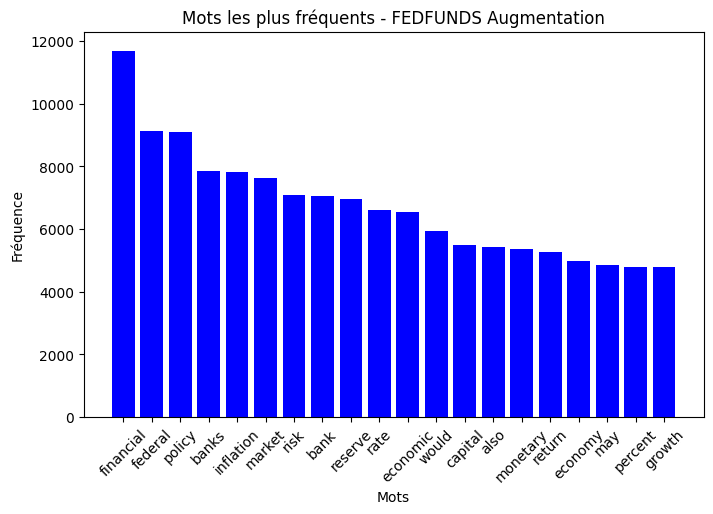

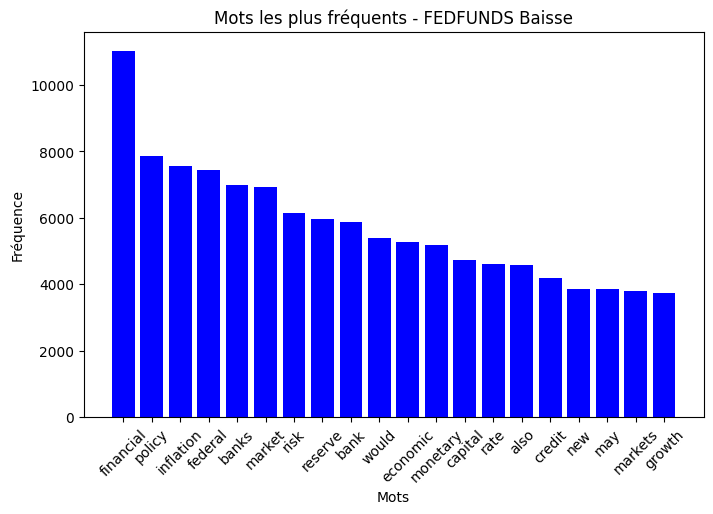

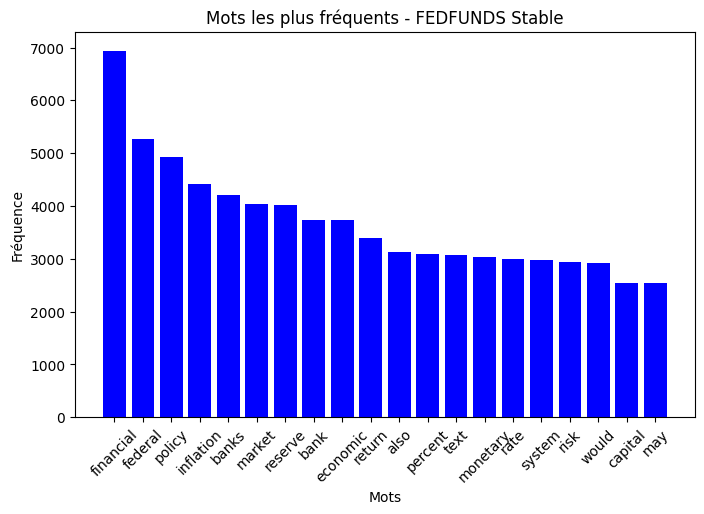

In [40]:
def plot_top_words(top_words, title):
    words, counts = zip(*top_words)

    plt.figure(figsize=(8, 5))
    plt.bar(words, counts, color="blue")
    plt.xlabel("Mots")
    plt.ylabel("Fréquence")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_top_words(top_words_augmentation, "Mots les plus fréquents - FEDFUNDS Augmentation")
plot_top_words(top_words_baisse, "Mots les plus fréquents - FEDFUNDS Baisse")
plot_top_words(top_words_stable, "Mots les plus fréquents - FEDFUNDS Stable")

## II - Modélisation

### 1 - Etat de l'art

#### 1. Modèles basés sur des représentations vectorielles

##### Naïve Bayes (NB) : 
Les modèles Naïve Bayes, comme le **Multinomial Naïve Bayes**, s’appuient sur la règle de Bayes et supposent l’indépendance conditionnelle des mots. Malgré cette hypothèse simplificatrice, ces modèles sont performants sur de petits corpus et avec des représentations telles que **Bag-of-Words (BoW)** ou **TF-IDF**.  

- **Avantages** : rapide, robuste sur des données limitées  
- **Limites** : forte dépendance à l’hypothèse d’indépendance des mots  

##### Régression Logistique (LR)  
Approche linéaire qui optimise une fonction logistique pour classifier les textes. Son efficacité dépend fortement de la qualité des représentations vectorielles utilisées (**TF-IDF, BoW**). Elle est souvent plus performante que Naïve Bayes lorsque les relations entre mots sont plus complexes.  

- **Avantages** : interprétable, efficace sur des corpus de taille moyenne  
- **Limites** : linéarité, sensible aux données bruitées  

##### Support Vector Machines (SVM)
Les SVM sont bien adaptés à la classification de texte en raison de leur capacité à maximiser la séparation entre les classes dans des espaces de grande dimension. Ils sont souvent utilisés avec **TF-IDF** pour une meilleure généralisation.  

- **Avantages** : robuste aux données bruitées, efficace avec peu de données  
- **Limites** : coûteux en calcul sur de très grands corpus 

Dans notre cas, nous avons décidé de réaliser un modèle TF-IDF + LR et TF-IDF + SVM. Pourquoi TF-IDF et pas BoW ?
Le TF-IDF utilise BoW (transforme un texte en un vecteur de fréquences de mots) mais pondère les mots en fonction de leur importance dans le corpus.
Mots rares et informatifs ont un poids plus élevé.

---

#### 2️. Modèles basés sur des représentations avancées 

##### Word Embeddings (Word2Vec ou GloVe) 
Contrairement aux méthodes classiques, ces modèles apprennent des représentations continues des mots dans un espace vectoriel, capturant des relations sémantiques et syntaxiques.  

- **Word2Vec** : basé sur des architectures **CBOW** et **Skip-gram**, il permet d’apprendre des représentations contextuelles.  
- **GloVe** : utilise la co-occurrence globale des mots dans un corpus pour obtenir des vecteurs denses.  

- **Avantages** : capture les relations sémantiques  
- **Limites** : nécessite un grand corpus pour être efficace  

---

#### 3️. Modèles neuronaux

##### Réseaux de neurones récurrents (RNN, LSTM, GRU)
Les **RNN** et leurs variantes comme **LSTM** et **GRU** sont capables de capturer des relations séquentielles et contextuelles dans les textes. Ils sont adaptés aux tâches de classification où l’ordre des mots est important.  

- **Avantages** : capture les dépendances contextuelles  
- **Limites** : entraînement lent, problème de gradient évanescent  

##### Transformers (BERT, GPT)
L’introduction des **Transformers** a révolutionné la classification de texte. Des modèles comme **BERT** utilisent des mécanismes d’attention pour comprendre le contexte global d’un texte. Fine-tunés sur des tâches spécifiques, ils surpassent les méthodes classiques en performance.  

- **Avantages** : compréhension fine du contexte, meilleures performances  
- **Limites** : coûteux en calcul, besoin de grands volumes de données  

### 2 - Modélisation basée sur des représentations vectorielles

#### a) Nettoyage des données

In [41]:
nltk.download("punkt")
nltk.download("wordnet")

stop_words= set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

def clean_text(text):

    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return " ".join(tokens)

df["clean_text"] = df["text"].apply(clean_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [42]:
df.head(3)

,date_speech,title,speaker,text,date_cible,FEDFUNDS,Diff,FEDFUNDS_Augmentation,FEDFUNDS_Baisse,FEDFUNDS_Stable,clean_text
0,1996-06-13,Bank supervision in a world economy,Chairman Alan Greenspan,Remarks by Chairman Alan Greenspan Bank superv...,1996-07-01,5.40,0.13,1,0,0,remark chairman alan greenspan bank supervisio...
1,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.","Remarks by Governor Edward W. Kelley, Jr. Deve...",1996-07-01,5.40,0.13,1,0,0,remark governor edward w kelley jr development...
2,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,Monetary Policy Objectives and Strategy I wan...,1996-10-01,5.24,-0.06,0,1,0,monetary policy objective strategy want share ...


#### b) Vectorisation

In [45]:
def get_fedfunds_class(row):
    if row["FEDFUNDS_Augmentation"] == 1:
        return "Augmentation"
    elif row["FEDFUNDS_Baisse"] == 1:
        return "Baisse"
    else:
        return "Stable"

df["FEDFUNDS_Classe"] = df.apply(get_fedfunds_class, axis=1)

In [ ]:
y = df["FEDFUNDS_Classe"]
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [49]:
X = df["clean_text"]

In [51]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000, min_df=2)
X_tfidf = tfidf_vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

#### c) Multinomial Naïve Bayes

Attention : nos classes sont déséquilibrées 

In [56]:
class_counts = df['FEDFUNDS_Classe'].value_counts()
class_weights = {
    'Augmentation': 1/class_counts['Augmentation'],
    'Baisse': 1/class_counts['Baisse'],
    'Stable': 1/class_counts['Stable']
}

In [57]:
# Conversion en liste ordonnée selon l'encodage de LabelEncoder
class_prior = []
for class_name in label_encoder.classes_:
    class_prior.append(class_weights[class_name])

# Normalisation pour que la somme soit égale à 1
class_prior = np.array(class_prior) / sum(class_prior)

print(f"Probabilités a priori ajustées: {class_prior}")

Probabilités a priori ajustées: [0.24134779 0.30756171 0.45109051]


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [59]:
nb_classifier = MultinomialNB(class_prior=class_prior)
nb_classifier.fit(X_train, y_train)

MultinomialNB(class_prior=array([0.24134779, 0.30756171, 0.45109051]))

In [62]:
y_pred = nb_classifier.predict(X_test)
print("Rapport de classification:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"Précision équilibrée: {balanced_accuracy_score(y_test, y_pred):.4f}")

Rapport de classification:
              precision    recall  f1-score   support

Augmentation       0.44      0.67      0.53       157
      Baisse       0.41      0.35      0.38       124
      Stable       0.48      0.12      0.19        84

    accuracy                           0.43       365
   macro avg       0.44      0.38      0.37       365
weighted avg       0.44      0.43      0.40       365

Précision équilibrée: 0.3782


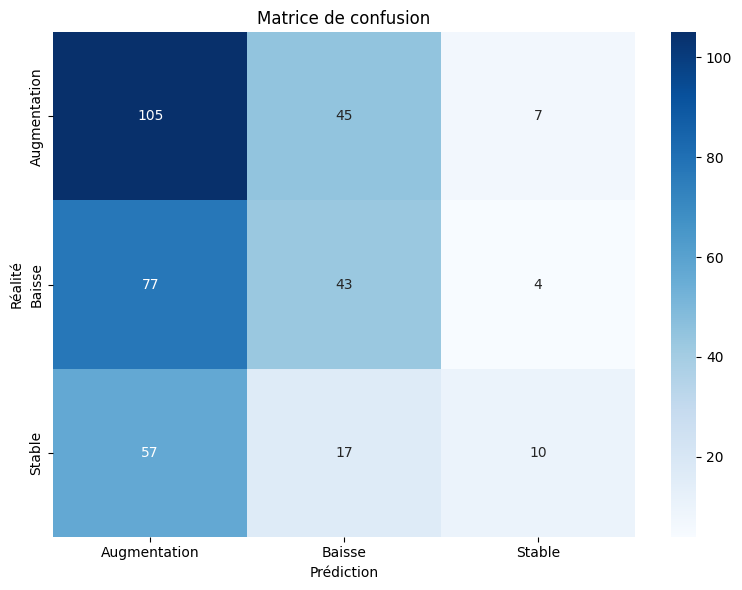

In [63]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.show()

**Conclusions du modèle Multinomial Naive Bayes :**

- *1ère constatation* : Nous observons un biais vers la classe Augmentation. Malgré l'ajustement des probabilités a priori (class_prior), le modèle présente une forte tendance à classer les discours de la FED comme annonçant des augmentations de taux, même lorsqu'ils annoncent en réalité des baisses ou une stabilité.
- *2de constatation* : On a une faible performance sur Stable. Cette classe étant la moins représentée initialement dans notre dataset, elle est particulièrement mal identifiée, avec seulement 10 classifications correctes sur 84 cas réels.
- *3ème constatation* : Le modèle confond les classes Baisse et Augmentation. La confusion majeure se situe entre ces deux classes, suggérant que le vocabulaire utilisé dans ces discours pourrait être similaire ou que d'autres facteurs non captés par le modèle sont déterminants. En effet, lorsqu'on regarde les top20 des mots qui sont les plus fréquents dans les discours par classe, 13 mots sont communs entre les classes Baisse et Augmentation. Leur position dans le classement n'est pas identique mais l'approche simpliste du langage ne capture que la fréquence des mots sans tenir compte de leur contexte.
- *4ème constatation* : L'hypothèse d'indépendance avancée par le modèle Naive Bayes suppose l'indépendance entre les mots, hypothèse rarement vérifiée dans le langage naturel et particulièrement dans des discours économiques structurés comme les discours de la FED.

#### d) Regression logistique

---

In [ ]:
columns_to_drop2 = ['text_length','title_length']
df = df.drop(columns=columns_to_drop2)

In [ ]:
df.head(3)

,rating,title,text
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just..."
2,5.0,Yes!,"Smells good, feels great!"


## 4 - Data preparation

### a) Catégorisation binaire (positif/négatif)

In [ ]:
df['labels_rating'] = df['rating'].apply(lambda x: 'positif' if x >= 3 else 'négatif')
df.head(3)

,rating,title,text,labels_rating
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,positif
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",positif
2,5.0,Yes!,"Smells good, feels great!",positif


### b) Encodage de "rating"

Lorsqu'on utilise un modèle de NLP pour la classification, il est préférable d'encoder la cible en entiers plutôt qu'en one-hot car :

- **Correspondance avec la couche de sortie** : La couche softmax attend des indices (0 à N-1) pour chaque classe.
- **Efficacité** : La fonction de perte CrossEntropyLoss combine softmax et calcul de la perte de manière optimisée avec des labels entiers.
- **Simplicité** : Cela simplifie le pipeline de fine-tuning, en accord avec la majorité des tutoriels BERT en PyTorch.

In [ ]:
df['bin_rating'] = pd.get_dummies(df['labels_rating'], drop_first=True).astype(int)

In [ ]:
df.head(3)

,rating,title,text,labels_rating,bin_rating
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,positif,1
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",positif,1
2,5.0,Yes!,"Smells good, feels great!",positif,1


### Création des df (train/valid/test)

In [ ]:
#Train & Test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
#Validation
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

#Tailles
print(f'Train size: {len(train_df)} | Validation size: {len(val_df)} | Test size: {len(test_df)}')

Train size: 505099 | Validation size: 56123 | Test size: 140306


C:\Users\Lia\AppData\Local\Temp\ipykernel_11396\2193690250.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='labels_rating', data=train_df, ax=axes[0], palette='viridis')
C:\Users\Lia\AppData\Local\Temp\ipykernel_11396\2193690250.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='labels_rating', data=val_df, ax=axes[1], palette='viridis')
C:\Users\Lia\AppData\Local\Temp\ipykernel_11396\2193690250.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='labels_rating', data=test_df, ax=axes[2], palette='viridis')


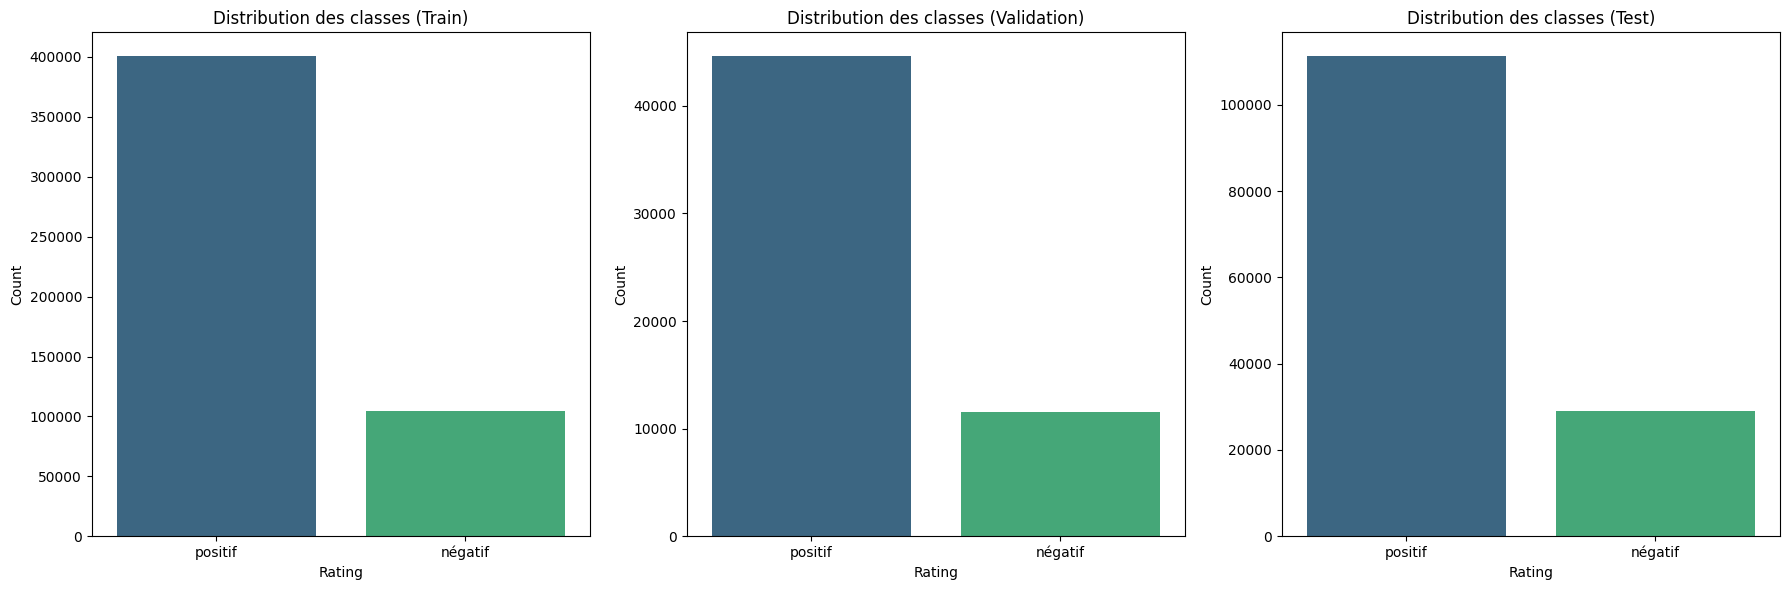

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#Train
sns.countplot(x='labels_rating', data=train_df, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution des classes (Train)')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')

#Valid
sns.countplot(x='labels_rating', data=val_df, ax=axes[1], palette='viridis')
axes[1].set_title('Distribution des classes (Validation)')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Count')

#Test
sns.countplot(x='labels_rating', data=test_df, ax=axes[2], palette='viridis')
axes[2].set_title('Distribution des classes (Test)')
axes[2].set_xlabel('Rating')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Tokenization colonne "text"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

**Calcul du nombre de tokens dans chaque avis**

Concepts clefs : 
- **Troncature** : consiste à couper les textes trop longs pour respecter la limite maximale de tokens du modèle (ex. 512 pour BERT). Cela garantit que chaque séquence est compatible avec l’architecture du modèle et évite les erreurs d’indexation.

- **Padding** : ajoute des tokens spéciaux (`[PAD]`) aux textes plus courts pour les aligner à une même longueur. Cela est essentiel pour le traitement par lots (batch processing), permettant un calcul efficace et cohérent sur toutes les séquences.

Ensemble, ces deux techniques assurent que les entrées du modèle sont de taille uniforme, facilitant l’entraînement et l’inférence.

In [ ]:
def compute_token_lengths_txt(df, tokenizer):
    
    all_texts = df['text'].tolist()
    all_encodings = tokenizer(all_texts, truncation=False, padding=False)#Tokenisation sans troncature ni padding
    token_lengths = [len(ids) for ids in all_encodings['input_ids']]
    
    #Calcul de la longueur moyenne et max
    mean_length = sum(token_lengths)/len(token_lengths)
    max_length = max(token_lengths)
    
    return mean_length, max_length

In [ ]:
train_mean_length, train_max_length = compute_token_lengths_txt(train_df, tokenizer)
val_mean_length, val_max_length = compute_token_lengths_txt(val_df, tokenizer)
test_mean_length, test_max_length = compute_token_lengths_txt(test_df, tokenizer)
print(f"Train - Longueur moyenne : {train_mean_length:.2f} tokens | Longueur maximale : {train_max_length} tokens")
print(f"Validation - Longueur moyenne : {val_mean_length:.2f} tokens | Longueur maximale : {val_max_length} tokens")
print(f"Test - Longueur moyenne : {test_mean_length:.2f} tokens | Longueur maximale : {test_max_length} tokens")

Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors


Train - Longueur moyenne : 43.35 tokens | Longueur maximale : 3629 tokens
Validation - Longueur moyenne : 43.59 tokens | Longueur maximale : 2118 tokens
Test - Longueur moyenne : 43.46 tokens | Longueur maximale : 2252 tokens


Le modèle CamemBERT utilisé dans notre cas ne peut gérer des textes trop longs (limité à 512 tokens). 
Pour résoudre ce problème, ces textes doivent être tokenizés entièrement en utilisant une fenêtre glissante.

----------------------------------------------------------------------------------------------------------------------------------

In [ ]:
"""train_df_copy = train_df.copy()
val_df_copy = val_df.copy()
test_df_copy = test_df.copy()"""

'train_df_copy = train_df.copy()\nval_df_copy = val_df.copy()\ntest_df_copy = test_df.copy()'

**Tokenization des textes par fenêtre glissante**

In [ ]:
"""def sliding_window_tokenizer(df, tokenizer, max_length=512, stride=256):
    encodings = []
    for text in df['text']:        
        encoding = tokenizer(text, truncation=False, padding=False) #sans troncature ni padding initiaux
        tokens = encoding['input_ids']
        
        # Fenêtres glissantes
        for i in range(0, len(tokens), stride):
            window = tokens[i:i + max_length]
            
            #Si fenêtre + courte que la taille max, on la complète avec padding
            if len(window) < max_length:
                window= window + [tokenizer.pad_token_id]*(max_length - len(window))
            encodings.append(window)
    
    return np.array(encodings)"""

"def sliding_window_tokenizer(df, tokenizer, max_length=512, stride=256):\n    encodings = []\n    for text in df['text']:        \n        encoding = tokenizer(text, truncation=False, padding=False) #sans troncature ni padding initiaux\n        tokens = encoding['input_ids']\n        \n        # Fenêtres glissantes\n        for i in range(0, len(tokens), stride):\n            window = tokens[i:i + max_length]\n            \n            #Si fenêtre + courte que la taille max, on la complète avec padding\n            if len(window) < max_length:\n                window= window + [tokenizer.pad_token_id]*(max_length - len(window))\n            encodings.append(window)\n    \n    return np.array(encodings)"

In [ ]:
"""train_encodings = sliding_window_tokenizer(train_df_copy, tokenizer, max_length=512, stride=256)
val_encodings = sliding_window_tokenizer(val_df_copy, tokenizer, max_length=512, stride=256)
test_encodings = sliding_window_tokenizer(test_df_copy, tokenizer, max_length=512, stride=256)"""

'train_encodings = sliding_window_tokenizer(train_df_copy, tokenizer, max_length=512, stride=256)\nval_encodings = sliding_window_tokenizer(val_df_copy, tokenizer, max_length=512, stride=256)\ntest_encodings = sliding_window_tokenizer(test_df_copy, tokenizer, max_length=512, stride=256)'

In [ ]:
"""#Nb de fenêtres créées
print(f"Nombre de fenêtres créées pour le train : {len(train_encodings)}")
print(f"Nombre de fenêtres créées pour le val : {len(val_encodings)}")
print(f"Nombre de fenêtres créées pour le test : {len(test_encodings)}")"""

'#Nb de fenêtres créées\nprint(f"Nombre de fenêtres créées pour le train : {len(train_encodings)}")\nprint(f"Nombre de fenêtres créées pour le val : {len(val_encodings)}")\nprint(f"Nombre de fenêtres créées pour le test : {len(test_encodings)}")'

**Association de chaque segment à son label d'origine**

In [ ]:
"""def duplicate_labels(df, tokenizer, max_length=512, stride=256):
    duplicated_labels = []
    for text, label in zip(df['text'], df['bin_rating']):
        encoding = tokenizer(text, truncation=False, padding=False)
        tokens = encoding['input_ids']
        # Calculer le nombre de fenêtres créées pour ce texte
        num_windows = (len(tokens) - 1) // stride + 1
        duplicated_labels.extend([label] * num_windows)
    return duplicated_labels"""

"def duplicate_labels(df, tokenizer, max_length=512, stride=256):\n    duplicated_labels = []\n    for text, label in zip(df['text'], df['bin_rating']):\n        encoding = tokenizer(text, truncation=False, padding=False)\n        tokens = encoding['input_ids']\n        # Calculer le nombre de fenêtres créées pour ce texte\n        num_windows = (len(tokens) - 1) // stride + 1\n        duplicated_labels.extend([label] * num_windows)\n    return duplicated_labels"

In [ ]:
"""train_labels = duplicate_labels(train_df_copy, tokenizer, max_length=512, stride=256)
val_labels = duplicate_labels(val_df_copy, tokenizer, max_length=512, stride=256)
test_labels = duplicate_labels(test_df_copy, tokenizer, max_length=512, stride=256)"""

'train_labels = duplicate_labels(train_df_copy, tokenizer, max_length=512, stride=256)\nval_labels = duplicate_labels(val_df_copy, tokenizer, max_length=512, stride=256)\ntest_labels = duplicate_labels(test_df_copy, tokenizer, max_length=512, stride=256)'

**Conclusion de cette idée** :

Le fenêtrage glissant est utile pour gérer des textes longs qui dépassent la limite de 512 tokens pour Camembert. Cependant, pour la classification de texte, il est souvent préférable de tronquer les textes longs plutôt que de les diviser en fenêtres glissantes pour les raisons suivantes :

- **Perte de contexte global** : Chaque fenêtre (segment) est traitée indépendamment.
- **Introduction de bruit** : Certaines fenêtres peuvent ne pas contenir d'informations pertinentes pour la classification.
- **Augmentation de la taille du dataset et du temps d'entraînement**.

=> La meilleure solution est donc de **tronquer les données**. Cela permet de conserver le contexte global tout en respectant la limite du modèle.

-----------------------------------------------------------------------------------------------------------------------------------

**Tokenization avec troncature**

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        encoding = self.tokenizer(
            self.texts[index],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[index], dtype=torch.long)
        }


In [ ]:
# Création des datasets
train_dataset = SentimentDataset(train_df["text"].tolist(), train_df["bin_rating"].tolist(), tokenizer)
val_dataset = SentimentDataset(val_df["text"].tolist(), val_df["bin_rating"].tolist(), tokenizer)
test_dataset = SentimentDataset(test_df["text"].tolist(), test_df["bin_rating"].tolist(), tokenizer)

In [ ]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, model_name, num_classes=2):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids=None, attention_mask=None):  # Correction : valeurs par défaut à None
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.fc(self.dropout(outputs.logits))
        return logits


In [ ]:
# Initialisation du modèle
model = SentimentClassifier("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [ ]:
# Définir la loss et l'optimiseur
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-7)  # Très petit lr au début

In [ ]:
from torch_lr_finder import LRFinder, TrainDataLoaderIter

In [ ]:
class HuggingFaceTrainDataLoaderIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        inputs = {
            "input_ids": batch_data["input_ids"].to(device),
            "attention_mask": batch_data["attention_mask"].to(device),
        }
        labels = batch_data["label"].to(device)
        return inputs, labels


In [ ]:
train_loader_iter = HuggingFaceTrainDataLoaderIter(train_loader)

In [ ]:
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader_iter, end_lr=1, num_iter=75)
lr_finder.plot()

  0%|          | 0/75 [00:00<?, ?it/s]


TypeError: SentimentClassifier.forward() missing 1 required positional argument: 'attention_mask'